In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
LOCAL_DATA_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/'
import json
# you need to download the scene graph data from visual genome, it's not included in dario's folder (and i don't have write access there)
with open(LOCAL_DATA_PATH+'raw/scene_graphs.json', 'r') as f:
    scene_graphs_dict = json.load(f)

def build_graph(g_dict):
        G = nx.DiGraph(image_id=g_dict['image_id'])
        G.labels = {}
        for obj in g_dict['objects']:
            G.add_node(obj['object_id'], w=obj['w'], h=obj['h'], x=obj['x'], y=obj['y'], attributes=obj.get('attributes',[]), name=obj['names'][0])
            G.labels[obj['object_id']] = obj['names'][0]
        for rel in g_dict['relationships']:
            G.add_edge(rel['subject_id'], rel['object_id'], synsets=rel['synsets'] ,relationship_id=rel['relationship_id'], predicate=rel['predicate'])
        return G
graphs = [] 
for g_dict in tqdm(scene_graphs_dict):
    graphs.append(build_graph(g_dict))

100%|██████████| 108077/108077 [00:17<00:00, 6091.41it/s]


In [2]:
def plot_graph(g):
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    max_y = max([y for x,y in pos.values()])
    n_nodes_top = len([n for n in g.nodes if pos[n][1] == max_y])
    longest_label = max([len(g.labels[n]) for n in g.nodes])
    plt.figure(figsize=(max(n_nodes_top*longest_label/10,15),5))
    nx.draw(g,pos=pos, with_labels=True, node_size=10, node_color="lightgray", font_size=8)
    nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=nx.get_edge_attributes(g,'predicate'),font_size=8)
    plt.show()

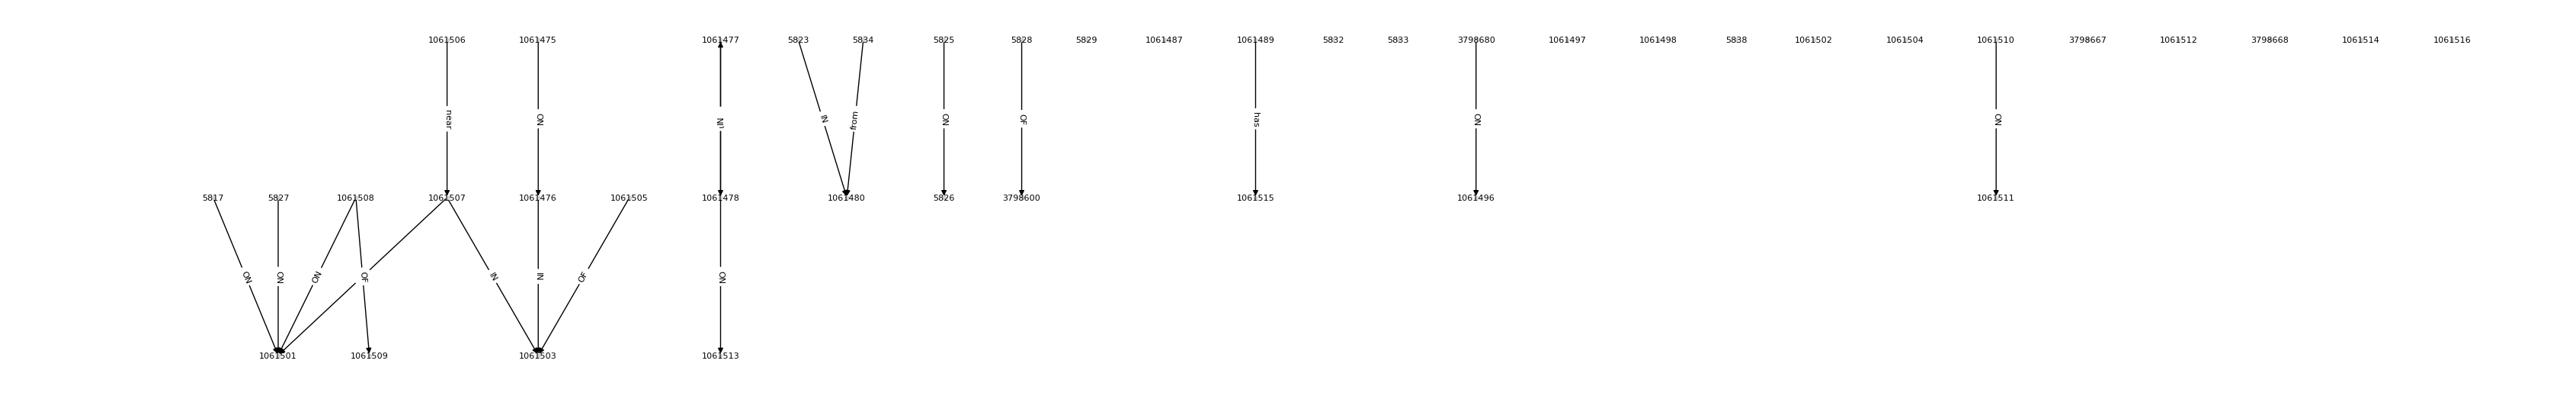

[[1061475, 1061476, 1061503], [1061477, 1061478, 1061513], [1061506, 1061507, 1061503], [1061506, 1061507, 1061501]]


In [3]:
g = graphs[35]
def get_all_paths(g, max_length):
    paths = [[n] for n in g.nodes]
    for _ in range(max_length):
        new_paths = []
        for path in paths:
            for n in g.successors(path[-1]):
                if n not in path: # the graphs actually have cycles, so we need to check for that
                    new_paths.append(path+[n])
        if len(new_paths) == 0:
            break
        paths = new_paths
    return paths

def assemble_sentence_draft(g, path):
    entities = [ g.labels[n] for n in path]
    predicates = [ g[path[i]][path[i+1]]['predicate'] for i in range(len(path)-1)]
    for i in range(len(predicates)):
        if predicates[i] == 'ON':
            predicates[i] = 'on top of'
        if predicates[i] == 'by':
            predicates[i] = 'stands next to'
    sentence = "The scene shows a "
    for i in range(len(path)-1):
        sentence += entities[i]
        sentence += " " + predicates[i]
        sentence += " " + entities[i+1] + ". "
    return sentence


plot_graph(g)
print(get_all_paths(g, 5))




In [4]:
from random import choice
paths = get_all_paths(g, 5)
print(paths)
some_path = choice(paths)
print(assemble_sentence_draft(g, some_path))


[[1061475, 1061476, 1061503], [1061477, 1061478, 1061513], [1061506, 1061507, 1061503], [1061506, 1061507, 1061501]]
The scene shows a food near sink. sink IN kitchen. 


In [5]:
import os
import openai
from dotenv import load_dotenv
import re
load_dotenv()
from PIL import Image as PIL_Image


openai.api_key = os.getenv("OPENAI_API_KEY")

def assemble_sentence(g, sentence_draft):
    prompt = f"Question: Please correct the grammar of the following into one sentence (present tense):\n\n{sentence_draft}.\n\nAnswer:"
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        temperature=0.3,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].text[1:]
    
def print_image(image_id):
    DATA_PATH = '/local/home/stuff/visual-genome/'
    try:
        image = PIL_Image.open(DATA_PATH + 'VG_100K/' + str(image_id) + '.jpg')
    except:
        image = PIL_Image.open(DATA_PATH + 'VG_100K_2/' + str(image_id) + '.jpg')
    plt.imshow(image)
    plt.show()

2330576


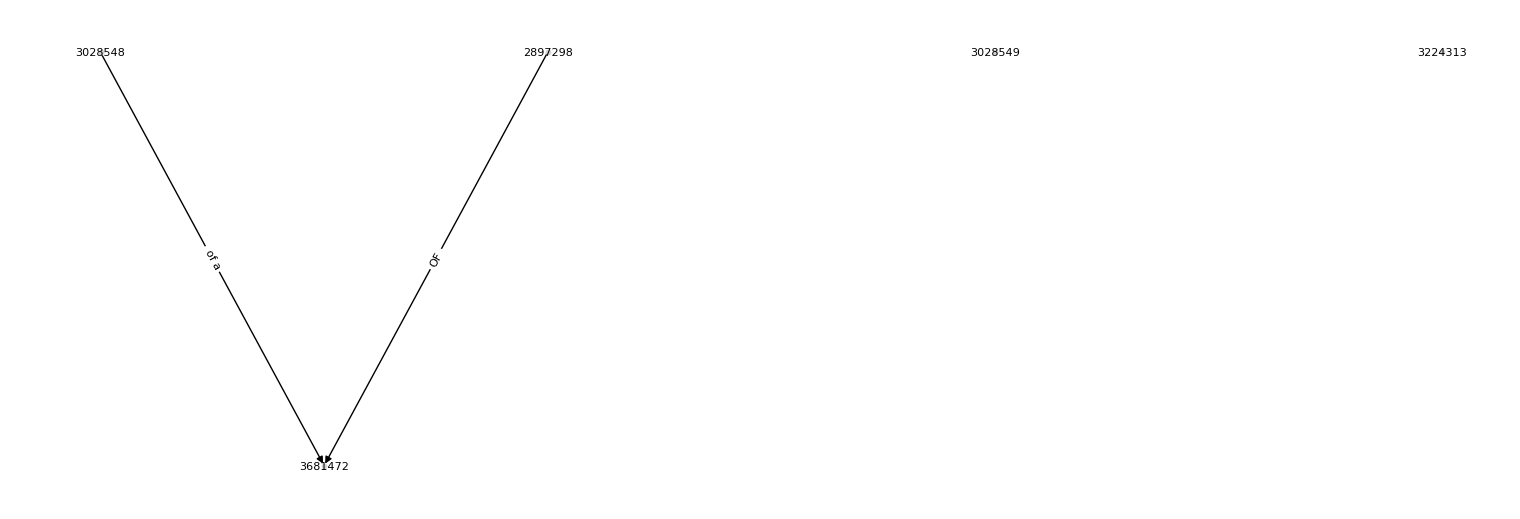

The scene shows a finger OF human. 
The scene shows a human finger.


In [6]:
g = choice(graphs)
image_id = g.graph['image_id']
# print_image(image_id)
print(image_id)
plot_graph(g)
paths = get_all_paths(g, 5)
some_path = choice(paths)
sentence_draft = assemble_sentence_draft(g, some_path)
print(sentence_draft)
caption = assemble_sentence(g, sentence_draft)
print(caption)

In [7]:
# 2350352
# cows on top of grass. grass on top of field. 
# Cows graze on the grass in the field.

# Modify the function to find the text of a full subgraph

In [19]:
def subg_get_sentence(sentence_draft):
    prompt = f"Question: Please correct the grammar of the following into one sentence (present tense):\n\n{sentence_draft}.\n\nAnswer:"
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        temperature=0.3,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].text[1:]

def subg_get_sentence_draft(edges):
    entities = [(g.labels[a],g.labels[b]) for (a,b) in edges]
    predicates = [ g[a][b]['predicate'] for (a,b) in edges]
    # for i in range(len(predicates)):
    #     if predicates[i] == 'ON':
    #         predicates[i] = 'on top of'
    #     if predicates[i] == 'by':
    #         predicates[i] = 'stands next to'
    sentence = ""
    for (a,b),p in zip(entities, predicates):
        srel =  a
        srel += " " + p
        srel += " " + b + ", "
        if srel not in sentence:
            sentence += srel
        else:
            sentence = sentence.replace(srel, "multiple " + srel)
    return sentence[0:-2] + ". "

def get_connected_component_edges(g):
    node_sets = list(nx.weakly_connected_components(g))
    edges = []
    lonely_nodes = []
    for node_set in node_sets:
        edges_subgraph = list(g.subgraph(node_set).edges)
        if len(edges_subgraph) > 0:
            edges.append(edges_subgraph)
        else:
            lonely_nodes += list(node_set)
    return edges, lonely_nodes

def graph_get_description_from_draft(sentence_draft):
    # you are given is to avoid the model saying "I"
    prompt = f"Question: You are given a description of an image. Please correct the grammar of the following, while keeping each sentence.\n\n{sentence_draft}.\n\nAnswer:"
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        temperature=0.3,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].text[1:]

def graph_get_description(g):
    sentence = ""
    raw_draft = "The scene contains "
    components, lonely_nodes = get_connected_component_edges(g)
    for node in lonely_nodes:
        name = g.labels[node]
        if name not in raw_draft:
            how_often = len([n for n in g.nodes if g.labels[n] == name])
            raw_draft += ("a" if how_often==1 else str(how_often)) + " " + g.labels[node] + ", "
    sentence += subg_get_sentence(raw_draft) + " "
    for subgraph_edges in components:
        sentence_draft = subg_get_sentence_draft(subgraph_edges)
        if sentence_draft not in raw_draft: # avoid duplicates, which happens regularly
            raw_draft += sentence_draft + " "
            sentence += subg_get_sentence(sentence_draft) + " "
    return sentence

52484


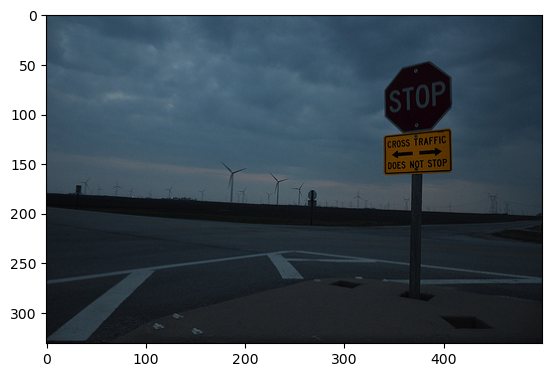

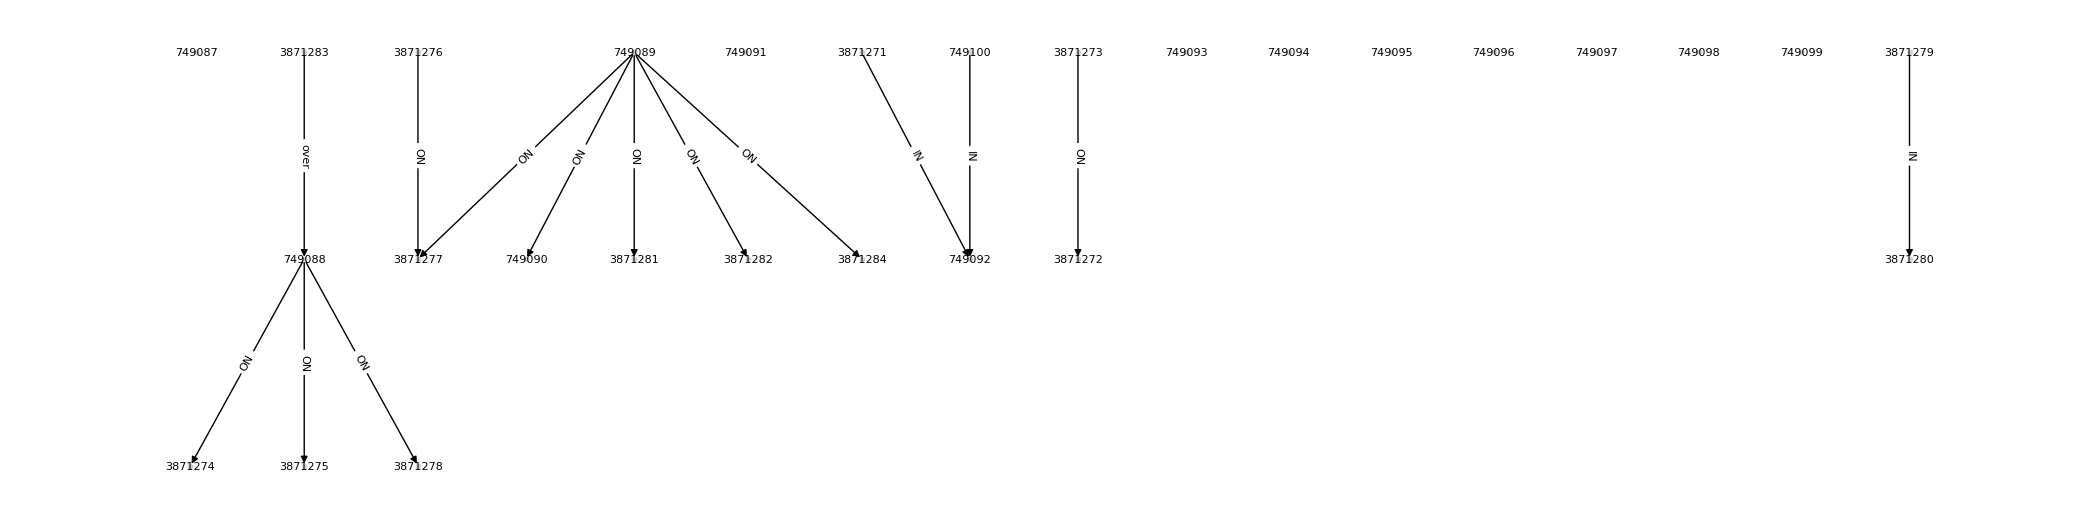

[[(749088, 3871274), (749088, 3871275), (749088, 3871278), (3871283, 749088)], [(749089, 749090), (749089, 3871277), (749089, 3871281), (749089, 3871282), (749089, 3871284), (3871276, 3871277)], [(749100, 749092), (3871271, 749092)], [(3871273, 3871272)], [(3871279, 3871280)]]
The scene contains a sky, a line, a spot, a square, screws, a building, a road, an arrow, and land. Wind turbines are in the background, picture, and field, with skies overhead. Multiple signs are posted on the pole, post, and street. Trash and squares are on the sidewalk. Signs are backed onto the pole. There are holes in the pavement. 


In [22]:
import random
idx = random.randint(0, len(graphs))
print(idx)
g = graphs[idx]
image_id = g.graph['image_id']
print_image(image_id)
plot_graph(g)
print(get_connected_component_edges(g)[0])
print(graph_get_description(g))
# sentence = graph_get_description(raw_draft) # transforming all at once somehow is not wokring as well